In [9]:
# Módulos
using Random
using CSV
using DataFrames
using CategoricalArrays
using GLM

# Se carga el script
include("GRNN.jl")

GRNN (generic function with 4 methods)

# Base de incendios forestales
Se empieza por cargar la base de datos:

In [128]:
# Ruta relativa al archivo CSV
ruta_datos = "../Bases de datos/forestfires.csv"

# Leer el archivo CSV y almacenarlo en un DataFrame
df = CSV.read(ruta_datos, DataFrame)

# Mostrar las primeras filas del DataFrame
println(first(df, 5))

5×13 DataFrame
 Row │ X      Y      month    day      FFMC     DMC      DC       ISI      temp     RH     wind     rain     area    
     │ Int64  Int64  String3  String3  Float64  Float64  Float64  Float64  Float64  Int64  Float64  Float64  Float64 
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │     7      5  mar      fri         86.2     26.2     94.3      5.1      8.2     51      6.7      0.0      0.0
   2 │     7      4  oct      tue         90.6     35.4    669.1      6.7     18.0     33      0.9      0.0      0.0
   3 │     7      4  oct      sat         90.6     43.7    686.9      6.7     14.6     33      1.3      0.0      0.0
   4 │     8      6  mar      fri         91.7     33.3     77.5      9.0      8.3     97      4.0      0.2      0.0
   5 │     8      6  mar      sun         89.3     51.3    102.2      9.6     11.4     99      1.8      0.0      0.0


In [130]:
# Obtener y mostrar los niveles (valores únicos) de las columnas month y day
unique_months = unique(df.month)
unique_days = unique(df.day)

println("Niveles de la columna month: $unique_months")
println("Niveles de la columna day: $unique_days")

Niveles de la columna month: String3["mar", "oct", "aug", "sep", "apr", "jun", "jul", "feb", "jan", "dec", "may", "nov"]
Niveles de la columna day: String3["fri", "tue", "sat", "sun", "mon", "wed", "thu"]


In [131]:
# Convertir las columnas 'month' y 'day' a datos categóricos con niveles específicos
df.month = categorical(df.month, ordered=true, levels=["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"])
df.day = categorical(df.day, ordered=true, levels=["mon", "tue", "wed", "thu", "fri", "sat", "sun"])

# Obtener los niveles codificados numéricamente
month_levels = levels(df.month)
day_levels = levels(df.day)

7-element Vector{String3}:
 "mon"
 "tue"
 "wed"
 "thu"
 "fri"
 "sat"
 "sun"

In [132]:
# Imprimir los niveles y sus índices numéricos
println("Niveles de la columna month codificados numéricamente:")
for (i, level) in enumerate(month_levels)
    println("$level: $i")
end

Niveles de la columna month codificados numéricamente:
jan: 1
feb: 2
mar: 3
apr: 4
may: 5
jun: 6
jul: 7
aug: 8
sep: 9
oct: 10
nov: 11
dec: 12


In [133]:
println("\nNiveles de la columna day codificados numéricamente:")
for (i, level) in enumerate(day_levels)
    println("$level: $i")
end


Niveles de la columna day codificados numéricamente:
mon: 1
tue: 2
wed: 3
thu: 4
fri: 5
sat: 6
sun: 7


In [134]:
function encode_categorical(column)
    encoding_dict = Dict(level => i for (i, level) in enumerate(levels(column)))
    return [get(encoding_dict, value, missing) for value in column]
end

df.month = encode_categorical(df.month);
df.day = encode_categorical(df.day);

In [135]:
# Mostrar las primeras filas del DataFrame para verificar la codificación
println("\nPrimeras filas del DataFrame con columnas codificadas:")
println(first(df, 5))


Primeras filas del DataFrame con columnas codificadas:
5×13 DataFrame
 Row │ X      Y      month  day    FFMC     DMC      DC       ISI      temp     RH     wind     rain     area    
     │ Int64  Int64  Int64  Int64  Float64  Float64  Float64  Float64  Float64  Int64  Float64  Float64  Float64 
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │     7      5      3      5     86.2     26.2     94.3      5.1      8.2     51      6.7      0.0      0.0
   2 │     7      4     10      2     90.6     35.4    669.1      6.7     18.0     33      0.9      0.0      0.0
   3 │     7      4     10      6     90.6     43.7    686.9      6.7     14.6     33      1.3      0.0      0.0
   4 │     8      6      3      5     91.7     33.3     77.5      9.0      8.3     97      4.0      0.2      0.0
   5 │     8      6      3      7     89.3     51.3    102.2      9.6     11.4     99      1.8      0.0      0.0


# Aplicación de GRNN

In [2]:
y = df.area;
y = log.(y.+1)
x = select(df, Not(:area));
x = Matrix(x);

UndefVarError: UndefVarError: `df` not defined

In [278]:
# Semilla aleatoria para reproducibilidad
Random.seed!(123)

# Definir la proporción de datos para el conjunto de entrenamiento
n = size(df, 1)
n0 = Int(round(0.9 * n))

# Obtener un arreglo de índices aleatorios
indices = shuffle(1:n)

# Dividir los datos en conjuntos de entrenamiento y prueba
ind_train = indices[1:n0]
ind_test = indices[n0+1:end]

x0 = x[ind_train, :]
y0 = y[ind_train]
x1 = x[ind_test, :]
y1 = y[ind_test]

# Función para centrar y estandarizar los datos
function center_and_standardize!(x)
    μ = mean(x, dims=1)
    σ = std(x, dims=1)
    x .= (x .- μ) ./ σ
    return x, μ, σ
end

# Centrar y estandarizar x1 y x0
x1, μ1, σ1 = center_and_standardize!(x1);
x0, μ0, σ0 = center_and_standardize!(x0);
# Cantidad de centroides
k0 = Int(round(0.8*size(x0, 1)));

## Regresión lineal previa

In [279]:

# Calculamos X^T X
xtx = transpose(x0) * x0

# Calculamos la inversa de X^T X
xtx_inv = inv(xtx)

# Calculamos X^T Y
xty = transpose(x0) * y0

# Calculamos los coeficientes de regresión beta = (X^T X)^-1 * X^T Y
beta = xtx_inv * xty

# Calculamos las predicciones
y0_reg = x0 * beta
y1_reg = x1 * beta

# Calculamos los residuos
e0 = y0_reg - y0 ;
e1 = y1_reg - y1 ;


In [280]:
e1_pred = GRNN(x1, e0, x0, 1.5, "gaussiano", true, k0) 
y1_pred = y1_reg + e1_pred;

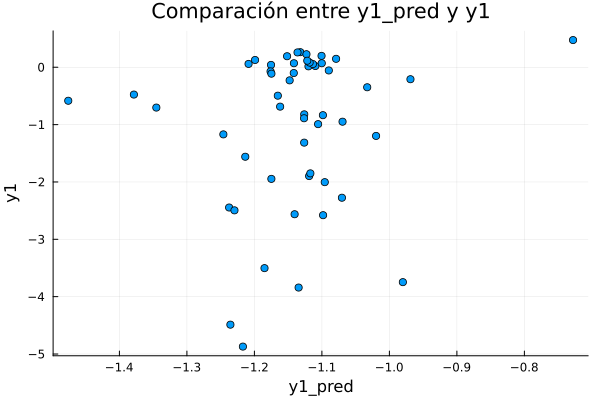

In [281]:
# Crear el gráfico de dispersión
scatter(e1_pred, e1, label="", xlabel="y1_pred", ylabel="y1", title="Comparación entre y1_pred y y1")

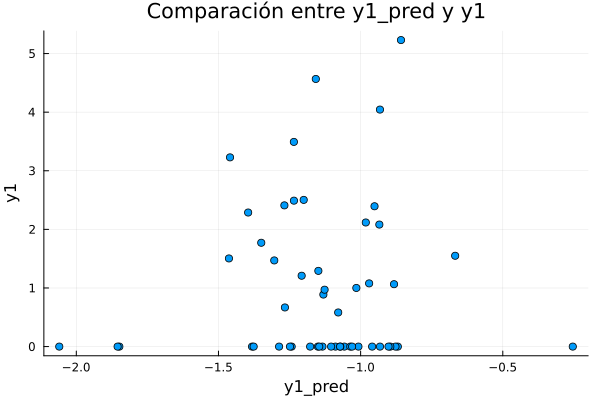

In [282]:
# Crear el gráfico de dispersión
scatter(y1_pred, y1, label="", xlabel="y1_pred", ylabel="y1", title="Comparación entre y1_pred y y1")

In [231]:
cor(y1, y1_pred)

-0.059011288451721385

Row,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64
1,7,5,3,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
2,7,4,10,2,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
3,7,4,10,6,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
4,8,6,3,5,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
5,8,6,3,7,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0
6,8,6,8,7,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0.0
7,8,6,8,1,92.3,88.9,495.6,8.5,24.1,27,3.1,0.0,0.0
8,8,6,8,1,91.5,145.4,608.2,10.7,8.0,86,2.2,0.0,0.0
9,8,6,9,2,91.0,129.5,692.6,7.0,13.1,63,5.4,0.0,0.0


## Ejemplo con regresión lineal

Se considera el modelo:

$$
Y = \beta_{0} + \beta_{1} X_{1} + \beta_{2} X_{2}    
$$

In [3]:

# Semilla aleatoria para reproducibilidad
Random.seed!(123)

# Número de observaciones
n = 1000

# Número de características
p = 4;

# Generar datos de características aleatorias
X = randn(n, p);

# Coeficientes verdaderos para la regresión lineal
β_true = randn(p);

# Ruido aleatorio
ε = 0.1 * randn(n);

# Generar la variable de respuesta
y = X * β_true + ε;


In [10]:
# Tamaño del conjunto de entrenamiento
n_train = round(Int, 0.8 * n);  # 80% de los datos para entrenamiento

# Dividir los datos en conjunto de entrenamiento (y0) y conjunto de prueba (y1)
y0 = y[1:n_train];
y1 = y[n_train+1:end];
# Dividir los datos en conjunto de entrenamiento (X0) y conjunto de prueba (X1)
x0 = X[1:n_train, :];
x1 = X[n_train+1:end, :];
h = 0.5
k0 = Int(round(0.2*n));

In [11]:
y1_pred = GRNN(x1, y0, x0, h);# , "gaussiano", true, k0


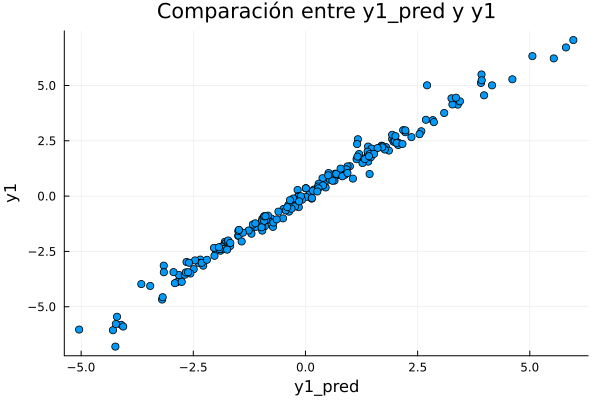

In [12]:
using Plots
# Crear el gráfico de dispersión
scatter(y1_pred, y1, label="", xlabel="y1_pred", ylabel="y1", title="Comparación entre y1_pred y y1")

